## Pre-trained model for the whole audio, not slices of the audio

In [1]:
# transformers
from datasets import load_dataset
from transformers import AutoFeatureExtractor,\
    AutoModelForAudioClassification, \
    TrainingArguments, \
    Trainer

# system management
import os
import IPython.display as ipd
import yaml
import time

# audio processing
import librosa
from scipy.io import wavfile
import soundfile as sf
from pydub import AudioSegment

# array data manipulation and plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2025-06-22 14:14:15.377752: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 14:14:15.909023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750626856.104994   24948 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750626856.205281   24948 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750626856.609904   24948 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

/home/sdtemple/mambaforge/envs/birdclef/lib/python3.12/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


I assume that the feature extractor and pre-trained model will need to be the same.

In [3]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True
    )
    return inputs

transformers uses path links to the data, instead of downloading the data upfront

In [ ]:
import datasets

# Example: list of file paths and labels

audio_files = []
labels = []

folder = '/mnt/d/acoustics-data/dbr-dataset/dataset/dog/'
files = os.listdir(folder)
wav_files = [folder + f for f in files if f.endswith('.wav')]
audio_files += wav_files
labels += ['dog'] * len(wav_files)

folder = '/mnt/d/acoustics-data/dbr-dataset/dataset/bird/'
files = os.listdir(folder)
wav_files = [folder + f for f in files if f.endswith('.wav')]
audio_files += wav_files
labels += ['bird'] * len(wav_files)

folder = '/mnt/d/acoustics-data/dbr-dataset/dataset/rain/'
files = os.listdir(folder)
wav_files = [folder + f for f in files if f.endswith('.wav')]
audio_files += wav_files
labels += ['rain'] * len(wav_files)

# Create dataset
data = {"audio": audio_files, "label": labels}
my_dataset = datasets.Dataset.from_dict(data)

# If your labels are strings, map them to integers
label2id = {label: str(i) for i, label in enumerate(set(labels))}
id2label = {v: k for k, v in label2id.items()}
my_dataset = my_dataset.map(lambda x: {"label": int(label2id[x["label"]])})

# Load audio (if needed)
my_dataset = my_dataset.cast_column("audio", datasets.Audio(sampling_rate=16000))

# Preprocess
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["audio"]]
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=16000, truncation=True
    )
    return inputs

encoded_dataset = my_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [5]:
num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained(
    "facebook/wav2vec2-base", num_labels=num_labels, label2id=label2id, id2label=id2label
)

/home/sdtemple/mambaforge/envs/birdclef/lib/python3.12/site-packages/transformers/configuration_utils.py:311: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Stratified split by label
split_dataset = encoded_dataset.train_test_split(test_size=0.2, seed=42)

This Trainer() class is how transformers operates, instead of writing custom training loops.

In [15]:
training_args = TrainingArguments(
    output_dir="./",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    num_train_epochs=5,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=split_dataset["train"],
    eval_dataset=split_dataset["test"],
    tokenizer=feature_extractor,
)

trainer.train()

/tmp/ipykernel_24948/1842708590.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/sdtemple/mambaforge/envs/birdclef/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,0.918947
2,No log,0.791019
3,No log,0.578524
4,No log,0.575975
5,No log,0.491102


/home/sdtemple/mambaforge/envs/birdclef/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/sdtemple/mambaforge/envs/birdclef/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/sdtemple/mambaforge/envs/birdclef/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/sdtemple/mambaforge/envs/birdclef/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_m

TrainOutput(global_step=75, training_loss=0.7752696736653646, metrics={'train_runtime': 433.6654, 'train_samples_per_second': 1.384, 'train_steps_per_second': 0.173, 'total_flos': 5447194387200000.0, 'train_loss': 0.7752696736653646, 'epoch': 5.0})

In [23]:
from sklearn.metrics import classification_report, \
    accuracy_score, \
    f1_score, \
    auc, \
    recall_score, \
    precision_score, \
    precision_recall_curve, \
    roc_curve
from sklearn.metrics import confusion_matrix

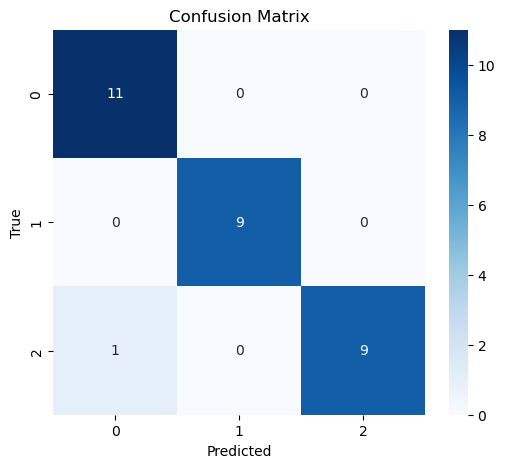

In [ ]:
pr = trainer.predict(split_dataset["test"])
all_preds = np.argmax(pr.predictions,axis=1)
all_labels = pr.label_ids

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()